Targets: 
1. Implementing a basic structure of the model which would serve as a base for future iterations.
2. We are including GAP layer directly, because we want to use FC layer and are targeting 8k parameters. GAP layer doesn't destroy spatial information as compared to flatten.

Results: 
  1. Best Train accuracy: 98.33% (15th epoch)
  2. Best Test accuracy:  98.99% (14th epoch)
  3. Parameters: 7,682

Analysis:
1. Model is converging very slowly. Might take many more epochs to reach target accuracy.
2. Model is light and not overfitting.

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                     ])

# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


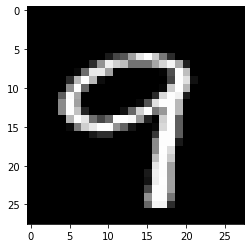

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

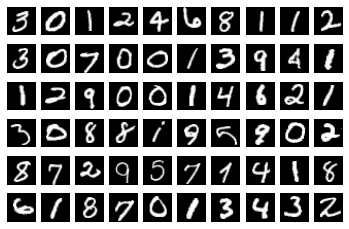

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cblock1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=False),    # Input -  28x28x1, Output -  28x28x8, RF - 3x3
            nn.ReLU(),
            nn.Conv2d(8, 10, 3, padding=1, bias=False),   # Input -  28x28x8, Output -  28x28x10, RF- 5x5
            nn.ReLU(),
        )

        self.tblock1 = nn.Sequential(
            nn.MaxPool2d(2, 2),                           # Input - 28x28x10, Output - 14x14x10, RF - 6x6
        )

        self.cblock2 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=1, bias=False),  # Input - 14x14x10, Output - 14x14x16, RF - 10x10
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # Input - 14x14x16, Output - 14x14x16, RF - 14x14
            nn.ReLU(),
        )

        self.tblock2 = nn.Sequential(
            nn.MaxPool2d(2, 2),                           # Input - 14x14x16, Output -   7x7x16, RF - 16x16
        )

        self.cblock3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # Input -   7x7x16, Output -   7x7x16, RF - 24x24
            nn.ReLU(),
        )

        self.outblock = nn.Sequential(
            nn.AvgPool2d(7, 7),                           # Input -   7x7x16, Output -   1x1x16, RF - 48x48
            nn.Conv2d(16, 32, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(32, 10, 1),
            nn.Flatten(),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.cblock1(x)
        x = self.tblock1(x)
        x = self.cblock2(x)
        x = self.tblock2(x)
        x = self.cblock3(x)
        x = self.outblock(x)
        return x

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3           [-1, 10, 28, 28]             720
              ReLU-4           [-1, 10, 28, 28]               0
         MaxPool2d-5           [-1, 10, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]           1,440
              ReLU-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,304
              ReLU-9           [-1, 16, 14, 14]               0
        MaxPool2d-10             [-1, 16, 7, 7]               0
           Conv2d-11             [-1, 16, 7, 7]           2,304
             ReLU-12             [-1, 16, 7, 7]               0
        AvgPool2d-13             [-1, 16, 1, 1]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Loss=1.8459259271621704 Batch_id=937 Accuracy=14.14: 100%|██████████| 938/938 [00:21<00:00, 43.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 1.9663, Accuracy: 2586/10000 (25.86%)

EPOCH: 1


Loss=0.19338160753250122 Batch_id=937 Accuracy=74.77: 100%|██████████| 938/938 [00:21<00:00, 44.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1812, Accuracy: 9454/10000 (94.54%)

EPOCH: 2


Loss=0.3712470531463623 Batch_id=937 Accuracy=94.29: 100%|██████████| 938/938 [00:21<00:00, 43.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1497, Accuracy: 9539/10000 (95.39%)

EPOCH: 3


Loss=0.04861253872513771 Batch_id=937 Accuracy=96.07: 100%|██████████| 938/938 [00:21<00:00, 43.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0762, Accuracy: 9749/10000 (97.49%)

EPOCH: 4


Loss=0.021913854405283928 Batch_id=937 Accuracy=96.80: 100%|██████████| 938/938 [00:21<00:00, 43.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0839, Accuracy: 9726/10000 (97.26%)

EPOCH: 5


Loss=0.006135261617600918 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [00:21<00:00, 44.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9819/10000 (98.19%)

EPOCH: 6


Loss=0.13173134624958038 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:21<00:00, 44.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9813/10000 (98.13%)

EPOCH: 7


Loss=0.02566540800035 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:21<00:00, 44.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9851/10000 (98.51%)

EPOCH: 8


Loss=0.23460476100444794 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:21<00:00, 44.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9877/10000 (98.77%)

EPOCH: 9


Loss=0.018722238019108772 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [00:21<00:00, 44.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9867/10000 (98.67%)

EPOCH: 10


Loss=0.021585192531347275 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:21<00:00, 44.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9879/10000 (98.79%)

EPOCH: 11


Loss=0.13691870868206024 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [00:21<00:00, 44.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9853/10000 (98.53%)

EPOCH: 12


Loss=0.05564168468117714 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:21<00:00, 44.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9887/10000 (98.87%)

EPOCH: 13


Loss=0.01286673080176115 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:21<00:00, 44.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9899/10000 (98.99%)

EPOCH: 14


Loss=0.00889351312071085 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:21<00:00, 44.57it/s]



Test set: Average loss: 0.0394, Accuracy: 9869/10000 (98.69%)



Text(0.5, 1.0, 'Test Accuracy')

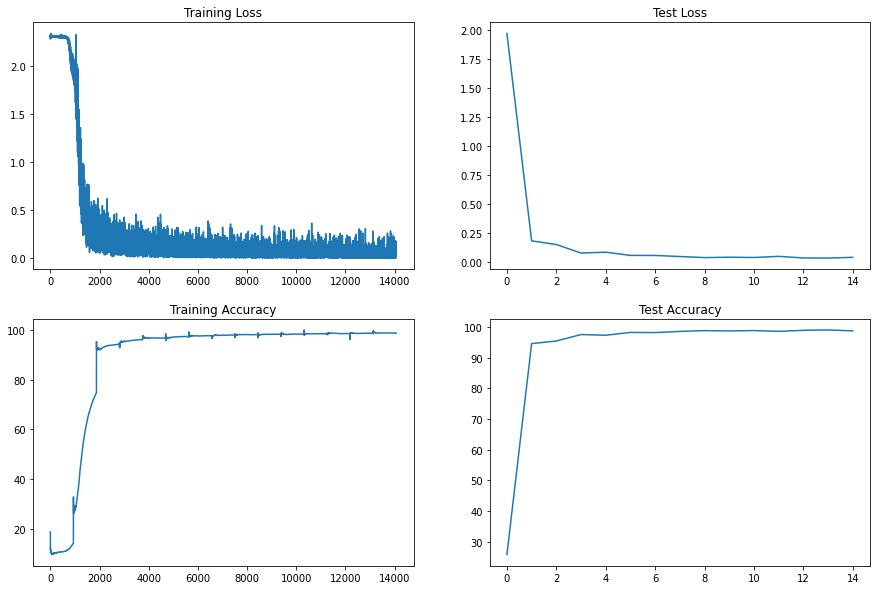

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")